In [1]:
#import the libraries
import math
import pandas_datareader as web
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
from keras.models import load_model
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pickle
import pandas as pd

In [2]:
#MACRO DEF

STOCK = 'GOOG'
EPOCHS = 100
model_path = "machine learning model/"+STOCK+"_OPEN_model.h5"
error_model_path = "machine learning model/"+STOCK+"_OPEN_error_model.h5"
error_data = "machine learning model/"+STOCK+"_OPEN_error_data.csv"
START_DATE = '2012-01-01'
END_DATE = '2022-03-05'
PREDICT_DATE = '2022-03-07'
ERR_EPOCHS = 120

In [3]:
#get the stock data
df = web.DataReader(STOCK, data_source='yahoo' , start=START_DATE , end=END_DATE)

#show the data
df


,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2012-01-03,332.827484,324.966949,325.250885,331.462585,7380561.0,331.462585
2012-01-04,333.873566,329.076538,331.273315,332.892242,5749470.0,332.892242
2012-01-05,330.745270,326.889740,329.828735,328.274536,6590410.0,328.274536
2012-01-06,328.767700,323.681763,328.344299,323.796326,5405987.0,323.796326
2012-01-09,322.291962,309.455078,322.042908,310.067780,11688849.0,310.067780
...,...,...,...,...,...,...
2022-02-28,2712.810059,2656.504883,2665.689941,2697.820068,1483800.0,2697.820068
2022-03-01,2722.219971,2667.570068,2689.600098,2683.360107,1232000.0,2683.360107
2022-03-02,2712.310059,2668.649902,2692.165039,2695.030029,1198300.0,2695.030029


In [4]:
#get the number of rows and column in the data set
df.shape

(2560, 6)

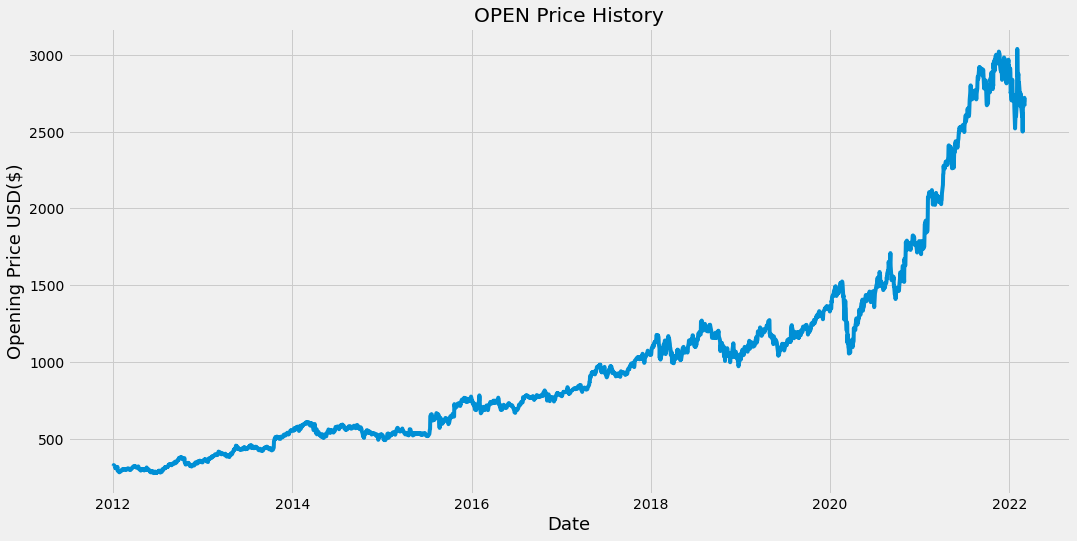

In [5]:
#Visualing the closing price history
plt.figure(figsize=(16,8))
plt.title('OPEN Price History')
plt.plot(df['Open'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('Opening Price USD($)', fontsize=18)
plt.show()

In [6]:
#Create a new data
data = df.filter(['Open'])
#convert the dataframe to a numpy array
dataset = data.values
#get the number of rows to train the model on
training_data_len = math.ceil(len(dataset)*.8)
training_data_len

2048

In [7]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

scaled_data

array([[0.01672395],
       [0.01890746],
       [0.01838371],
       ...,
       [0.87487793],
       [0.88481396],
       [0.86598966]])

In [8]:
#creating the training data set
#create the scaled training data set
train_data = scaled_data[0:training_data_len,:]
#split the data into x_train and y_train data sets
x_train = []
y_train = []
for i in range(60, len(train_data)):
    x_train.append(train_data[i-60:i,0])
    y_train.append(train_data[i,0])
    if i<=61:
        print(x_train)
        print(y_train)
        print()

[array([0.01672395, 0.01890746, 0.01838371, 0.01784551, 0.01556086,
       0.01253574, 0.01140696, 0.01280122, 0.01190543, 0.01293849,
       0.01197225, 0.01456573, 0.00545244, 0.0046343 , 0.0046921 ,
       0.00310098, 0.00210223, 0.00188551, 0.0031985 , 0.00409249,
       0.00444286, 0.00443022, 0.00547592, 0.00626155, 0.00845408,
       0.00872318, 0.00933362, 0.00858593, 0.0090591 , 0.00924693,
       0.00949798, 0.00767206, 0.00806036, 0.0078617 , 0.00932279,
       0.008427  , 0.00849021, 0.00835294, 0.0089688 , 0.010522  ,
       0.01118302, 0.01113606, 0.01085251, 0.00861663, 0.00879723,
       0.00897603, 0.00859856, 0.00716276, 0.00874304, 0.00987182,
       0.0101608 , 0.01093559, 0.01133833, 0.01274704, 0.01341348,
       0.01411602, 0.01557892, 0.01528996, 0.01565658, 0.0165596 ])]
[0.016814249727392233]

[array([0.01672395, 0.01890746, 0.01838371, 0.01784551, 0.01556086,
       0.01253574, 0.01140696, 0.01280122, 0.01190543, 0.01293849,
       0.01197225, 0.01456573, 0.0

In [9]:
#Convert the X_train and Y_train to numpy arrays
x_train , y_train = np.array(x_train), np.array(y_train)

In [10]:
#Reshape the data
x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape

(1988, 60, 1)

In [11]:
#Building the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape =(x_train.shape[1],1)))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=True))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

In [12]:
#compile the Model
model.compile(optimizer='adam', loss='mean_squared_error')


In [13]:
#train the model
model.fit(x_train, y_train, batch_size=32, epochs=EPOCHS)

Epoch 1/100
63/63 [==============================] - 20s 162ms/step - loss: 0.0030
Epoch 2/100
63/63 [==============================] - 10s 159ms/step - loss: 1.7041e-04
Epoch 3/100
63/63 [==============================] - 10s 156ms/step - loss: 1.5393e-04
Epoch 4/100
63/63 [==============================] - 10s 158ms/step - loss: 1.5449e-04
Epoch 5/100
63/63 [==============================] - 10s 153ms/step - loss: 1.8032e-04
Epoch 6/100
63/63 [==============================] - 10s 156ms/step - loss: 1.4858e-04
Epoch 7/100
63/63 [==============================] - 10s 157ms/step - loss: 1.3849e-04
Epoch 8/100
63/63 [==============================] - 10s 154ms/step - loss: 1.4462e-04
Epoch 9/100
63/63 [==============================] - 10s 156ms/step - loss: 1.3407e-04
Epoch 10/100
63/63 [==============================] - 6s 95ms/step - loss: 1.4883e-04
Epoch 11/100
63/63 [==============================] - 7s 112ms/step - loss: 1.2755e-04
Epoch 12/100
63/63 [============================

63/63 [==============================] - 10s 162ms/step - loss: 2.5719e-05
Epoch 95/100
63/63 [==============================] - 8s 128ms/step - loss: 2.9996e-05
Epoch 96/100
63/63 [==============================] - 5s 86ms/step - loss: 3.7425e-05
Epoch 97/100
63/63 [==============================] - 6s 103ms/step - loss: 3.2095e-05
Epoch 98/100
63/63 [==============================] - 10s 164ms/step - loss: 3.0207e-05
Epoch 99/100
63/63 [==============================] - 10s 163ms/step - loss: 3.9003e-05
Epoch 100/100
63/63 [==============================] - 10s 160ms/step - loss: 2.6324e-05


In [14]:
#create the testing data set
#create a new array containing scaled values from index 1543 to 2003
test_data = scaled_data[training_data_len - 60: , :]
#create the data sets x_test adn y_test
x_test = []
y_test = dataset[training_data_len:,:]
for i in range(60, len(test_data)):
    x_test.append(test_data[i-60:i,0])
    
    


In [15]:
#convert the data to a numpy array
x_test = np.array(x_test)

In [16]:
#resahpe the data
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))

In [17]:
#get the models predicted price values
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [18]:
#get the root mean squared error (RMSE)
rmse =  np.sqrt(np.mean(predictions - y_test)**2)
rmse

23.29186487197876

C:\Users\Abhishek Rao\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.7_qbz5n2kfra8p0\LocalCache\local-packages\Python37\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


KeyError: 'Close'

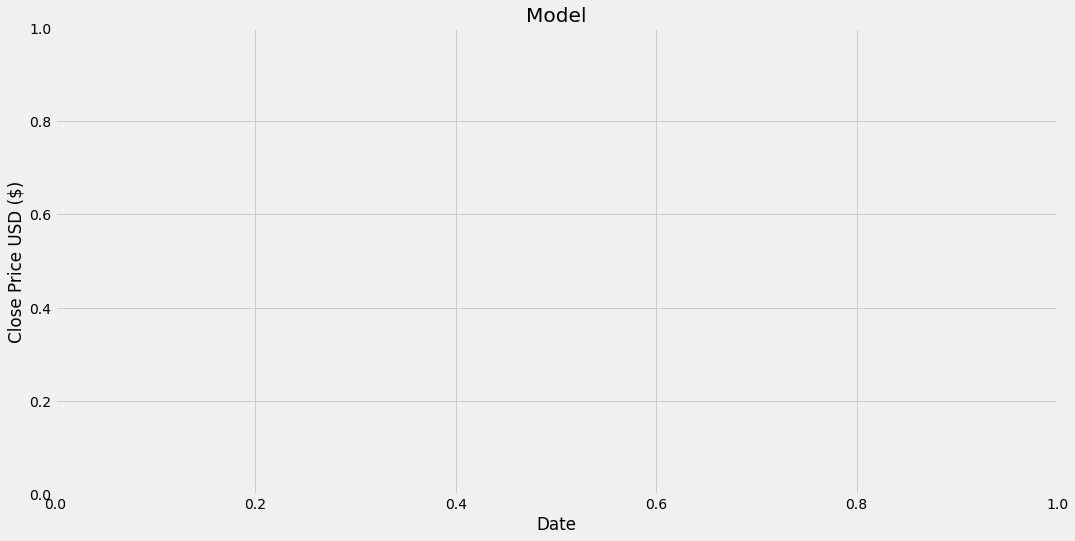

In [19]:
#plot the date
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions'] = predictions
#visualize the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train['Close'])
plt.plot(valid[['Close', 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()

In [ ]:
#show the valid and predicted prices
valid

In [ ]:
#get the Quote
stock_quote = web.DataReader(STOCK, data_source = 'yahoo', start=START_DATE, end=END_DATE)
#create new data frame
new_df = stock_quote.filter(['Open'])
#get the last 60 days closing price values and convert the dataframe to an array
last_60_days = new_df[-60:].values
#scale the data to be values between 0 and 1
last_60_days_scaled = scaler.fit_transform(last_60_days)
#create the empty list
x_test = []
#append the past 60 days
x_test.append(last_60_days_scaled)
#convert the x_test data set to a numpy array
x_test = np.array(x_test)
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
#get the predicted scaled price
pred_price = model.predict(x_test)
#undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)


In [ ]:
stock_quote2 = web.DataReader(STOCK, data_source = 'yahoo', start=START_DATE, end=PREDICT_DATE)
print(stock_quote2['Open'])

In [ ]:
model.save(model_path)
loaded_model = load_model(model_path)



In [ ]:
#The Error model
nperr = np.array(predictions - y_test)
nperr.shape
#np.savetxt(error_data,nperr,delimiter=",")
scaled_error = scaler.fit_transform(nperr)
plt.figure(figsize=(25,10))
plt.plot(nperr, linewidth=3)
x = np.linspace(0, 600, 600)
y = np.linspace(0, 0, 600)
plt.plot(x,y)
plt.title("1D error")
plt.show()

In [ ]:

nperr.shape
print(type(nperr))
training_errdata_len = math.ceil(len(nperr)*0.8)
training_errdata_len

In [ ]:
#Scale the error data
errscaler = MinMaxScaler(feature_range=(0,1))
scaled_errdata = errscaler.fit_transform(nperr)


In [ ]:
#creating the error training data set
#create the scaled error training data set
train_errdata = scaled_errdata[0:training_errdata_len,:]
#split the data into x_errtrain and y_errtrain data sets
x_errtrain = []
y_errtrain = []
for i in range(60, len(train_errdata)):
    x_errtrain.append(train_errdata[i-60:i,0])
    y_errtrain.append(train_errdata[i,0])
    if i<=61:
        print(x_errtrain)
        print(y_errtrain)
        print()

In [ ]:
#Convert the X_errtrain and Y_errtrain to numpy arrays
x_errtrain , y_errtrain = np.array(x_errtrain), np.array(y_errtrain)

In [ ]:
#Reshape the error data
x_errtrain = np.reshape(x_errtrain,(x_errtrain.shape[0],x_errtrain.shape[1],1))
x_errtrain.shape

In [ ]:
#Building the LSTM error model
errmodel = Sequential()
errmodel.add(LSTM(50, return_sequences=True, input_shape =(x_errtrain.shape[1],1)))

#adding a fourth fifth layer and some Dropout regularistion
errmodel.add(LSTM(units = 50, return_sequences = False))

errmodel.add(Dense(25))
errmodel.add(Dense(1))

In [ ]:
#compile the error Model
errmodel.compile(optimizer='adam', loss='mean_squared_error')


In [ ]:
#train the error model
errmodel.fit(x_errtrain, y_errtrain, batch_size=32, epochs=ERR_EPOCHS)

In [ ]:
#create the testing error data set
#create a new array containing scaled values 
test_errdata = scaled_errdata[training_errdata_len - 60: , :]
#create the data sets x_errtest adn y_errtest
x_errtest = []
y_errtest = nperr[training_errdata_len:,:]
for i in range(60, len(test_errdata)):
    x_errtest.append(test_errdata[i-60:i,0])


In [ ]:
#convert the error data to a numpy array
x_errtest = np.array(x_errtest)



In [ ]:
#resahpe the error data
x_errtest = np.reshape(x_errtest,(x_errtest.shape[0],x_errtest.shape[1],1))


In [ ]:
#get the models predicted error values
errpredictions = errmodel.predict(x_errtest)
errpredictions = errscaler.inverse_transform(errpredictions)

In [ ]:
#get the root mean squared error (RMSE)
error2d = []
print(errpredictions.shape)
error2d.append(errpredictions - y_errtest)
nperr2d = np.array(errpredictions - y_errtest)
scaled_error2d = errscaler.fit_transform(nperr2d)
#print(nperr)
plt.figure(figsize=(25,10))
plt.plot(scaled_error2d)
plt.title('scaled 2D Error')
plt.show()
rmse2d =  np.sqrt(np.mean(errpredictions - y_errtest)**2)
print(rmse2d)
#print(errpredictions)

In [ ]:
#plot the error data
print(nperr.shape)
dfnperr = pd.DataFrame(nperr, columns = ['Error'])
dfnperr.to_csv(error_data)
errtrain = dfnperr[:training_errdata_len]
errvalid = dfnperr[training_errdata_len:]
errvalid['Error Predictions'] = errpredictions
errvalid['Error2d'] = nperr2d
print(errvalid)
#visualize the data
plt.figure(figsize=(16,8))
plt.title('Error Model')
plt.xlabel('Date')
plt.ylabel('Error Close Price USD ($)')
plt.plot(errtrain['Error'])
plt.plot(errvalid[['Error', 'Error Predictions']])
plt.legend(['Error Train', 'Error Val', ' Error Predictions'], loc='lower right')
plt.show()

In [ ]:
#predict the error
last_60_days_error = dfnperr[-60:].values
print(last_60_days_error)

#scale the data to be values between 0 and 1
last_60_days_scaled_error = errscaler.transform(last_60_days_error)


#create the empty list
x_errtest=[]

#append the past 60 days 
x_errtest.append(last_60_days_scaled_error)

#convert the x_test data set to a numpy array
x_errtest = np.array(x_errtest)
x_errtest = np.reshape(x_errtest,(x_errtest.shape[0],x_errtest.shape[1],1))

pred_error = model.predict(x_errtest)

#undo the scaling
pred_error = errscaler.inverse_transform(pred_error)

print(pred_error)

dfnperr.tail()

In [ ]:
print("the predicted value with 1D error correction ")
print(pred_price[0][0]-pred_error[0][0])

In [ ]:
model.save(error_model_path)
loaded_model = load_model(error_model_path)


In [ ]:
stock_quote2 = web.DataReader(STOCK, data_source = 'yahoo', start=START_DATE, end=PREDICT_DATE)
print(stock_quote2['Close'])